In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import requests
import tweepy
import os
import time
import re
import matplotlib.pyplot as plt
import seaborn as sns


# Gather

In [2]:
# Loading the csv file

df_twitter0 = pd.read_csv('twitter-archive-enhanced.csv')
df_twitter0.head(6)


,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950...,13,10,None,None,None,None,None


Getting the tweet image predictions

In [3]:
# Dowmloading the tweet image predictions through the link provided by Udacity 

url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
imagereq = requests.get(url, allow_redirects=True)

open('image_predictions.tsv', 'wb').write(imagereq.content)

335079

In [4]:
# Inquisition of data from the tweet image predictions file


df_imagepredictions = pd.read_csv('image_predictions.tsv', sep = '\t')
df_imagepredictions.head(6)


,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
5,666050758794694657,https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg,1,Bernese_mountain_dog,0.651137,True,English_springer,0.263788,True,Greater_Swiss_Mountain_dog,0.016199,True


In [5]:
from tweepy import OAuthHandler
import json
from timeit import default_timer as timer

# Query Twitter API for each tweet in the Twitter archive and save JSON in a text file
# These are hidden to comply with Twitter's API terms and conditions
consumer_key = 'HIDDEN'
consumer_secret = 'HIDDEN'
access_token = 'HIDDEN'
access_secret = 'HIDDEN'

auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True)


In [6]:
#Tweet IDs for which to gather additional data via Twitter's API
tweetids = df_twitter0.tweet_id.values
len(tweetids)

2356

#Query Twitter's api for JSON data in relation to tweet id.

In [7]:
start = timer()

tweetids = df_twitter0.tweet_id.values

tweets_data = []
tweet_success = []
tweet_failure = []

for tweet_id in tweetids:
        try:
            data = api.get_status(tweet_id, tweet_mode='extended')
            tweets_data.append(data)
            tweet_success.append(tweet_id)
        except:
            tweet_failure.append(tweet_id)
            print(tweet_id)

# this stops the timer            
end = timer()

print(end - start)

892420643555336193
892177421306343426
891815181378084864
891689557279858688
891327558926688256
891087950875897856
890971913173991426
890729181411237888
890609185150312448
890240255349198849
890006608113172480
889880896479866881
889665388333682689
889638837579907072
889531135344209921
889278841981685760
888917238123831296
888804989199671297
888554962724278272
888202515573088257
888078434458587136
887705289381826560
887517139158093824
887473957103951883
887343217045368832
887101392804085760
886983233522544640
886736880519319552
886680336477933568
886366144734445568
886267009285017600
886258384151887873
886054160059072513
885984800019947520
885528943205470208
885518971528720385
885311592912609280
885167619883638784
884925521741709313
884876753390489601
884562892145688576
884441805382717440
884247878851493888
884162670584377345
883838122936631299
883482846933004288
883360690899218434
883117836046086144
882992080364220416
882762694511734784
882627270321602560
882268110199369728
882045870035

820749716845686786
820690176645140481
820494788566847489
820446719150292993
820314633777061888
820078625395449857
820013781606658049
819952236453363712
819924195358416896
819711362133872643
819588359383371776
819347104292290561
819238181065359361
819227688460238848
819015337530290176
819015331746349057
819006400881917954
819004803107983360
818646164899774465
818627210458333184
818614493328580609
818588835076603904
818536468981415936
818307523543449600
818259473185828864
818145370475810820
817908911860748288
817827839487737858
817777686764523521
817536400337801217
817502432452313088
817423860136083457
817415592588222464
817181837579653120
817171292965273600
817120970343411712
817056546584727552
816829038950027264
816816676327063552
816697700272001025
816450570814898180
816336735214911488
816091915477250048
816062466425819140
816014286006976512
815990720817401858
815966073409433600
815745968457060357
815736392542261248
815639385530101762
815390420867969024
814986499976527872
814638523311

762464539388485633
762316489655476224
762035686371364864
761976711479193600
761750502866649088
761745352076779520
761672994376806400
761599872357261312
761371037149827077
761334018830917632
761292947749015552
761227390836215808
761004547850530816
760893934457552897
760656994973933572
760641137271070720
760539183865880579
760521673607086080
760290219849637889
760252756032651264
760190180481531904
760153949710192640
759943073749200896
759923798737051648
759846353224826880
759793422261743616
759566828574212096
759557299618865152
759447681597108224
759446261539934208
759197388317847553
759159934323924993
759099523532779520
759047813560868866
758854675097526272
758828659922702336
758740312047005698
758474966123810816
758467244762497024
758405701903519748
758355060040593408
758099635764359168
758041019896193024
757741869644341248
757729163776290825
757725642876129280
757611664640446465
757597904299253760
757596066325864448
757400162377592832
757393109802180609
757354760399941633
756998049151

707969809498152960
707776935007539200
707741517457260545
707738799544082433
707693576495472641
707629649552134146
707610948723478529
707420581654872064
707411934438625280
707387676719185920
707377100785885184
707315916783140866
707297311098011648
707059547140169728
707038192327901184
707021089608753152
707014260413456384
706904523814649856
706901761596989440
706681918348251136
706644897839910912
706593038911545345
706538006853918722
706516534877929472
706346369204748288
706310011488698368
706291001778950144
706265994973601792
706169069255446529
706166467411222528
706153300320784384
705975130514706432
705970349788291072
705898680587526145
705786532653883392
705591895322394625
705475953783398401
705442520700944385
705428427625635840
705239209544720384
705223444686888960
705102439679201280
705066031337840642
704871453724954624
704859558691414016
704847917308362754
704819833553219584
704761120771465216
704499785726889984
704491224099647488
704480331685040129
704364645503647744
704347321748

679872969355714560
679862121895714818
679854723806179328
679844490799091713
679828447187857408
679777920601223168
679736210798047232
679729593985699840
679722016581222400
679530280114372609
679527802031484928
679511351870550016
679503373272485890
679475951516934144
679462823135686656
679405845277462528
679158373988876288
679148763231985668
679132435750195208
679111216690831360
679062614270468097
679047485189439488
679001094530465792
678991772295516161
678969228704284672
678800283649069056
678798276842360832
678774928607469569
678767140346941444
678764513869611008
678755239630127104
678740035362037760
678708137298427904
678675843183484930
678643457146150913
678446151570427904
678424312106393600
678410210315247616
678399652199309312
678396796259975168
678389028614488064
678380236862578688
678341075375947776
678334497360859136
678278586130948096
678255464182861824
678023323247357953
678021115718029313
677961670166224897
677918531514703872
677895101218201600
677716515794329600
677700003327

669567591774625800
669564461267722241
669393256313184256
669375718304980992
669371483794317312
669367896104181761
669363888236994561
669359674819481600
669354382627049472
669353438988365824
669351434509529089
669328503091937280
669327207240699904
669324657376567296
669216679721873412
669214165781868544
669203728096960512
669037058363662336
669015743032369152
669006782128353280
669000397445533696
668994913074286592
668992363537309700
668989615043424256
668988183816871936
668986018524233728
668981893510119424
668979806671884288
668975677807423489
668967877119254528
668960084974809088
668955713004314625
668932921458302977
668902994700836864
668892474547511297
668872652652679168
668852170888998912
668826086256599040
668815180734689280
668779399630725120
668655139528511488
668645506898350081
668643542311546881
668641109086707712
668636665813057536
668633411083464705
668631377374486528
668627278264475648
668625577880875008
668623201287675904
668620235289837568
668614819948453888
668587383441

In [8]:
with open('tweet-json.txt', 'r') as f:
    data = f.readlines()

# remove the trailing "\n" from each line
data = map(lambda x: x.rstrip(), data)

# each element of 'data' is an individual JSON object.
# i want to convert it into an *array* of JSON objects
# which, in and of itself, is one large JSON object
# basically... add square brackets to the beginning
# and end, and have all the individual business JSON objects
# separated by a comma
data_json = "[" + ','.join(data) + "]"

# now, load it into pandas
twitter_counts_df = pd.read_json(data_json)

# ##The above code has been attained from stackoverflow in order to solve the trailing value error.

In [9]:
twitter_counts_df.info()
    

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 31 columns):
 #   Column                         Non-Null Count  Dtype              
---  ------                         --------------  -----              
 0   created_at                     2354 non-null   datetime64[ns, UTC]
 1   id                             2354 non-null   int64              
 2   id_str                         2354 non-null   int64              
 3   full_text                      2354 non-null   object             
 4   truncated                      2354 non-null   bool               
 5   display_text_range             2354 non-null   object             
 6   entities                       2354 non-null   object             
 7   extended_entities              2073 non-null   object             
 8   source                         2354 non-null   object             
 9   in_reply_to_status_id          78 non-null     float64            
 10  in_reply_to_status_id_st

In [10]:
twitter_counts_df.rename(columns={'id': 'tweet_id'}, inplace=True)

In [11]:
twitter_counts_df.head()

,created_at,tweet_id,id_str,full_text,truncated,display_text_range,entities,extended_entities,source,in_reply_to_status_id,...,favorite_count,favorited,retweeted,possibly_sensitive,possibly_sensitive_appealable,lang,retweeted_status,quoted_status_id,quoted_status_id_str,quoted_status
0,2017-08-01 16:23:56+00:00,892420643555336193,892420643555336192,This is Phineas. He's a mystical boy. Only eve...,False,"[0, 85]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 892420639486877696, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,39467,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN
1,2017-08-01 00:17:27+00:00,892177421306343426,892177421306343424,This is Tilly. She's just checking pup on you....,False,"[0, 138]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 892177413194625024, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,33819,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN
2,2017-07-31 00:18:03+00:00,891815181378084864,891815181378084864,This is Archie. He is a rare Norwegian Pouncin...,False,"[0, 121]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 891815175371796480, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,25461,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN
3,2017-07-30 15:58:51+00:00,891689557279858688,891689557279858688,This is Darla. She commenced a snooze mid meal...,False,"[0, 79]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 891689552724799489, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,42908,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN
4,2017-07-29 16:00:24+00:00,891327558926688256,891327558926688256,This is Franklin. He would like you to stop ca...,False,"[0, 138]","{'hashtags': [{'text': 'BarkWeek', 'indices': ...","{'media': [{'id': 891327551943041024, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,41048,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN


In [12]:
twitter_counts_df = twitter_counts_df[['tweet_id','favorite_count','retweet_count']]

In [13]:
twitter_counts_df.head()

,tweet_id,favorite_count,retweet_count
0,892420643555336193,39467,8853
1,892177421306343426,33819,6514
2,891815181378084864,25461,4328
3,891689557279858688,42908,8964
4,891327558926688256,41048,9774


# Assessment

# df_twitter0 Dataframe Analysis

In [14]:
df_twitter0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [15]:
df_twitter0.describe

<bound method NDFrame.describe of                 tweet_id  in_reply_to_status_id  in_reply_to_user_id  \
0     892420643555336193                    NaN                  NaN   
1     892177421306343426                    NaN                  NaN   
2     891815181378084864                    NaN                  NaN   
3     891689557279858688                    NaN                  NaN   
4     891327558926688256                    NaN                  NaN   
...                  ...                    ...                  ...   
2351  666049248165822465                    NaN                  NaN   
2352  666044226329800704                    NaN                  NaN   
2353  666033412701032449                    NaN                  NaN   
2354  666029285002620928                    NaN                  NaN   
2355  666020888022790149                    NaN                  NaN   

                      timestamp  \
0     2017-08-01 16:23:56 +0000   
1     2017-08-01 00:17:27 +0000

In [16]:
df_twitter0.head(3)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None


In [17]:
df_twitter0[df_twitter0.tweet_id.duplicated()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


In [18]:
df_twitter0['name'].value_counts()

None          745
a              55
Charlie        12
Cooper         11
Lucy           11
             ... 
Dex             1
Ace             1
Tayzie          1
Grizzie         1
Christoper      1
Name: name, Length: 957, dtype: int64

# #Imagepredictions Dataframe Analysis

In [19]:
df_imagepredictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [20]:
df_imagepredictions.sample(3)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
657,682303737705140231,https://pbs.twimg.com/media/CXgHoLnWAAA8i52.jpg,1,seat_belt,0.997659,False,Lakeland_terrier,0.001731,True,Airedale,0.000204,True
1958,865359393868664832,https://pbs.twimg.com/media/DAJfxqGVoAAnvQt.jpg,2,Chesapeake_Bay_retriever,0.832435,True,Labrador_retriever,0.163551,True,Weimaraner,0.002770,True
928,702684942141153280,https://pbs.twimg.com/media/CcBwOn0XEAA7bNQ.jpg,1,golden_retriever,0.514085,True,Chesapeake_Bay_retriever,0.173224,True,Brittany_spaniel,0.118384,True


# ##Extracting an image of a dog from the imagepredictions

In [21]:
from IPython.display import Image 
Image(url = 'https://pbs.twimg.com/media/Ct72q9jWcAAhlnw.jpg')

In [22]:
# This is the image extracted from tweet_id : 806242860592926720

In [23]:
df_imagepredictions[df_imagepredictions.tweet_id.duplicated()]

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog


In [24]:
### VALUE COUNTS OF ALL OTHER DOG 

In [25]:
df_imagepredictions['p2'].value_counts()

Labrador_retriever    104
golden_retriever       92
Cardigan               73
Chihuahua              44
Pomeranian             42
                     ... 
medicine_chest          1
quail                   1
horse_cart              1
waffle_iron             1
bagel                   1
Name: p2, Length: 405, dtype: int64

# ##Twitter Counts Analysis

In [26]:
twitter_counts_df.head()

,tweet_id,favorite_count,retweet_count
0,892420643555336193,39467,8853
1,892177421306343426,33819,6514
2,891815181378084864,25461,4328
3,891689557279858688,42908,8964
4,891327558926688256,41048,9774


In [27]:
twitter_counts_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   tweet_id        2354 non-null   int64
 1   favorite_count  2354 non-null   int64
 2   retweet_count   2354 non-null   int64
dtypes: int64(3)
memory usage: 55.3 KB


# Under Accuracy we look at innacurracy of data with respect to wrong data.

a)The retweet status timestamp is an object while the other statuses are floats.
b)The timestamp is an object while as it should be in date-time character. 

.We then look into Validity:
    
c)Under the df_twitter0 dataset there is retweets data which is a duplicate and thus these columns will be removed: retweet status user id and retweet status timestamp.
    
d)The dogs name have None as a name and others 'a', or 'an.'

e) The p1,p2,p3 under df_imagepredictions dataset are having invalid data since some dogs are wrongly labelled.

.Under Consitency

f)The rating factor should be on a range of upto 10 but there are other rate values.
g)There is a column named source under df_twitter0 which has HTML tags.

.Completeness

h) The twitter counts is missing some data

#Tidiness issues in data


#Under the dataset df_twitter0

1) The last columns in the data are in common to the variables: (floofer,pupper,puppo,dogoo)

#Under dataset df_imagepredictions

2) The dataset is of the same group of observation as the one in df_twitter0 which is one table which has dog rate information.

 We have found out 8 data quality issues and 2 Tidiness issues, which we are now going to clean in the next step.

# Clean

In this section we are going to clean the data as per the data wrangling stages.

. Define
. Code
. Test


In [28]:
##First make a copy of the tables before cleaning

df_twitter0_clean = df_twitter0.copy()
df_imagepredictions_clean = df_imagepredictions.copy()
twitter_counts_df_clean = twitter_counts_df.copy()

# Define


a)Merge the clean versions of df_twitter0, df_imagepredictions_clean, twitter_counts_df dataframes thus Correct the dog types

b)Create a column for the various dog types.

c) Remove columns no longer needed.

d)Delete retweets

e) Change tweet_id from an integer to a string in order to make analysis easier.

f)Change the timestamp to correct datetime.

g) Tweets that have missing data in the urls.

h)Standardize  the dog ratings to be rated at 10.

 # a)Merging of the clean versions of df_twitter,df_imagepredictions, and twitter_counts_df dataframes.

In [29]:
from functools import reduce
dfs = [df_twitter0_clean, df_imagepredictions_clean,twitter_counts_df_clean]
twitter_dog = reduce(lambda left, right:  pd.merge(left, right, on = 'tweet_id'), dfs)

In [30]:
twitter_dog.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2073 entries, 0 to 2072
Data columns (total 30 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2073 non-null   int64  
 1   in_reply_to_status_id       23 non-null     float64
 2   in_reply_to_user_id         23 non-null     float64
 3   timestamp                   2073 non-null   object 
 4   source                      2073 non-null   object 
 5   text                        2073 non-null   object 
 6   retweeted_status_id         79 non-null     float64
 7   retweeted_status_user_id    79 non-null     float64
 8   retweeted_status_timestamp  79 non-null     object 
 9   expanded_urls               2073 non-null   object 
 10  rating_numerator            2073 non-null   int64  
 11  rating_denominator          2073 non-null   int64  
 12  name                        2073 non-null   object 
 13  doggo                       2073 

In [31]:
twitter_dog.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,favorite_count,retweet_count
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,...,0.097049,False,bagel,0.085851,False,banana,0.076110,False,39467,8853
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,...,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True,33819,6514
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,...,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True,25461,4328
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,...,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False,42908,8964
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,...,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True,41048,9774


# b) Create a column for the different types of dogs.

In [32]:
twitter_dog['dog_type'] = twitter_dog['text'].str.extract('(doggo|floofer|pupper|puppo)')

In [33]:
twitter_dog.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,favorite_count,retweet_count,dog_type
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,...,False,bagel,0.085851,False,banana,0.076110,False,39467,8853,NaN
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,...,True,Pekinese,0.090647,True,papillon,0.068957,True,33819,6514,NaN
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,...,True,malamute,0.078253,True,kelpie,0.031379,True,25461,4328,NaN
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,...,False,Labrador_retriever,0.168086,True,spatula,0.040836,False,42908,8964,NaN
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,...,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True,41048,9774,NaN


In [34]:
twitter_dog.dog_type.value_counts()

pupper     230
doggo       75
puppo       29
floofer      3
Name: dog_type, dtype: int64

From the above line of code the output gives the total number of dogs that in the dataset by grouping them into the different types available.

# c) Deleting the retweets that have no values

In order to get the retweets with no value, I decided to begin by analysisng those with value and store them.

In [35]:
twitter_dog = twitter_dog[np.isnan(twitter_dog.retweeted_status_id)]

In [36]:
twitter_dog.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1994 entries, 0 to 2072
Data columns (total 31 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    1994 non-null   int64  
 1   in_reply_to_status_id       23 non-null     float64
 2   in_reply_to_user_id         23 non-null     float64
 3   timestamp                   1994 non-null   object 
 4   source                      1994 non-null   object 
 5   text                        1994 non-null   object 
 6   retweeted_status_id         0 non-null      float64
 7   retweeted_status_user_id    0 non-null      float64
 8   retweeted_status_timestamp  0 non-null      object 
 9   expanded_urls               1994 non-null   object 
 10  rating_numerator            1994 non-null   int64  
 11  rating_denominator          1994 non-null   int64  
 12  name                        1994 non-null   object 
 13  doggo                       1994 

# d) Deleting the columns that are not of importance to my analysis


In [37]:
twitter_dog = twitter_dog.drop(['retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp'], axis=1)

In [38]:
twitter_dog.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,...,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,favorite_count,retweet_count,dog_type
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,...,False,bagel,0.085851,False,banana,0.076110,False,39467,8853,NaN
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,...,True,Pekinese,0.090647,True,papillon,0.068957,True,33819,6514,NaN
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,...,True,malamute,0.078253,True,kelpie,0.031379,True,25461,4328,NaN
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,...,False,Labrador_retriever,0.168086,True,spatula,0.040836,False,42908,8964,NaN
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,...,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True,41048,9774,NaN


In [39]:
 twitter_dog.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1994 entries, 0 to 2072
Data columns (total 28 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   tweet_id               1994 non-null   int64  
 1   in_reply_to_status_id  23 non-null     float64
 2   in_reply_to_user_id    23 non-null     float64
 3   timestamp              1994 non-null   object 
 4   source                 1994 non-null   object 
 5   text                   1994 non-null   object 
 6   expanded_urls          1994 non-null   object 
 7   rating_numerator       1994 non-null   int64  
 8   rating_denominator     1994 non-null   int64  
 9   name                   1994 non-null   object 
 10  doggo                  1994 non-null   object 
 11  floofer                1994 non-null   object 
 12  pupper                 1994 non-null   object 
 13  puppo                  1994 non-null   object 
 14  jpg_url                1994 non-null   object 
 15  img_

# e) Change data type of tweet_id to a string

In [40]:
twitter_dog['tweet_id'] = twitter_dog['tweet_id'].astype(str)

In [41]:
twitter_dog.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1994 entries, 0 to 2072
Data columns (total 28 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   tweet_id               1994 non-null   object 
 1   in_reply_to_status_id  23 non-null     float64
 2   in_reply_to_user_id    23 non-null     float64
 3   timestamp              1994 non-null   object 
 4   source                 1994 non-null   object 
 5   text                   1994 non-null   object 
 6   expanded_urls          1994 non-null   object 
 7   rating_numerator       1994 non-null   int64  
 8   rating_denominator     1994 non-null   int64  
 9   name                   1994 non-null   object 
 10  doggo                  1994 non-null   object 
 11  floofer                1994 non-null   object 
 12  pupper                 1994 non-null   object 
 13  puppo                  1994 non-null   object 
 14  jpg_url                1994 non-null   object 
 15  img_

# f) Changing the Timestamps to the correct format


In [42]:
twitter_dog['timestamp'] = twitter_dog['timestamp'].str.slice(start=0, stop=-6)


In [43]:
import datetime

In [44]:
# Change the 'timestamp' column to a datetime object
twitter_dog['timestamp'] = pd.to_datetime(twitter_dog['timestamp'], format = "%Y-%m-%d %H:%M:%S")

In [45]:
twitter_dog.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1994 entries, 0 to 2072
Data columns (total 28 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   tweet_id               1994 non-null   object        
 1   in_reply_to_status_id  23 non-null     float64       
 2   in_reply_to_user_id    23 non-null     float64       
 3   timestamp              1994 non-null   datetime64[ns]
 4   source                 1994 non-null   object        
 5   text                   1994 non-null   object        
 6   expanded_urls          1994 non-null   object        
 7   rating_numerator       1994 non-null   int64         
 8   rating_denominator     1994 non-null   int64         
 9   name                   1994 non-null   object        
 10  doggo                  1994 non-null   object        
 11  floofer                1994 non-null   object        
 12  pupper                 1994 non-null   object        
 13  pup

The above output shows that the timestamp datatype has successfuly changed to the correct format.

# Drop tweets with missing data in the urls

In [46]:
twitter_dog = twitter_dog[twitter_dog.expanded_urls.notnull()]

In [47]:
twitter_dog.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1994 entries, 0 to 2072
Data columns (total 28 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   tweet_id               1994 non-null   object        
 1   in_reply_to_status_id  23 non-null     float64       
 2   in_reply_to_user_id    23 non-null     float64       
 3   timestamp              1994 non-null   datetime64[ns]
 4   source                 1994 non-null   object        
 5   text                   1994 non-null   object        
 6   expanded_urls          1994 non-null   object        
 7   rating_numerator       1994 non-null   int64         
 8   rating_denominator     1994 non-null   int64         
 9   name                   1994 non-null   object        
 10  doggo                  1994 non-null   object        
 11  floofer                1994 non-null   object        
 12  pupper                 1994 non-null   object        
 13  pup

In [48]:
twitter_dog['rating_numerator'] = twitter_dog['rating_numerator'].astype(float)

In [49]:
twitter_dog['rating_denominator'] = twitter_dog['rating_denominator'].astype(float)

In [50]:
twitter_dog.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1994 entries, 0 to 2072
Data columns (total 28 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   tweet_id               1994 non-null   object        
 1   in_reply_to_status_id  23 non-null     float64       
 2   in_reply_to_user_id    23 non-null     float64       
 3   timestamp              1994 non-null   datetime64[ns]
 4   source                 1994 non-null   object        
 5   text                   1994 non-null   object        
 6   expanded_urls          1994 non-null   object        
 7   rating_numerator       1994 non-null   float64       
 8   rating_denominator     1994 non-null   float64       
 9   name                   1994 non-null   object        
 10  doggo                  1994 non-null   object        
 11  floofer                1994 non-null   object        
 12  pupper                 1994 non-null   object        
 13  pup

In [51]:
import re

ratings_decimal_text = []
ratings_decimal_index = []
ratings_decimal = []

for i, text in twitter_dog['text'].iteritems():
    if bool(re.search('\d+\.\d+\/\d+', text)):
        ratings_decimal_text.append(text)
        ratings_decimal_index.append(i)
        ratings_decimal.append(re.search('\d+\.\d+', text).group())

  
#Print the rate that have decimals

ratings_decimal_text

['This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10 https://t.co/qjrljjt948',
 "This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS",
 "This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back https://t.co/QFaUiIHxHq",
 'Here we have uncovered an entire battalion of holiday puppers. Average of 11.26/10 https://t.co/eNm2S6p9BD']

In [52]:
# We need to print the rates that have decimal values

ratings_decimal_index

[40, 558, 614, 1451]

In [53]:
twitter_dog.loc[ratings_decimal_index[0],'rating_numerator'] = float(ratings_decimal[0])
twitter_dog.loc[ratings_decimal_index[1],'rating_numerator'] = float(ratings_decimal[1])
twitter_dog.loc[ratings_decimal_index[2],'rating_numerator'] = float(ratings_decimal[2])
twitter_dog.loc[ratings_decimal_index[3],'rating_numerator'] = float(ratings_decimal[3])

In [54]:
twitter_dog.loc[614]

tweet_id                                                778027034220126208
in_reply_to_status_id                                                  NaN
in_reply_to_user_id                                                    NaN
timestamp                                              2016-09-20 00:24:34
source                   <a href="http://twitter.com/download/iphone" r...
text                     This is Sophie. She's a Jubilant Bush Pupper. ...
expanded_urls            https://twitter.com/dog_rates/status/778027034...
rating_numerator                                                     11.27
rating_denominator                                                    10.0
name                                                                Sophie
doggo                                                                 None
floofer                                                               None
pupper                                                              pupper
puppo                    

In [55]:
# Display image of  614
Image(url= 'https://pbs.twimg.com/media/Cswbc2yWcAAVsCJ.jpg')

In [56]:
# The code has been referenced from a stackoverflow code.

twitter_dog['rating'] = twitter_dog['rating_numerator'] / twitter_dog['rating_denominator']

In [57]:
twitter_dog.sample(3)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,...,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,favorite_count,retweet_count,dog_type,rating
1683,673359818736984064,NaN,NaN,2015-12-06 04:34:25,"<a href=""http://twitter.com/download/iphone"" r...",This is Steve. He was just relaxing in hot tub...,https://twitter.com/dog_rates/status/673359818...,8.0,10.0,Steve,...,Brittany_spaniel,0.104046,True,Ibizan_hound,0.034832,True,1558,728,NaN,0.8
896,737678689543020544,NaN,NaN,2016-05-31 16:14:39,"<a href=""http://twitter.com/download/iphone"" r...",We only rate dogs. Pls stop sending in non-can...,https://twitter.com/dog_rates/status/737678689...,11.0,10.0,None,...,Cardigan,0.049874,True,Chihuahua,0.011603,True,5528,1509,NaN,1.1
841,745789745784041472,NaN,NaN,2016-06-23 01:25:06,"<a href=""http://twitter.com/download/iphone"" r...",This is Gus. He didn't win the Powerball. Quit...,https://twitter.com/dog_rates/status/745789745...,10.0,10.0,Gus,...,Shih-Tzu,0.008942,True,cocker_spaniel,0.001928,True,4437,1207,NaN,1.0


In [58]:
twitter_dog.loc[994]

tweet_id                                                717790033953034240
in_reply_to_status_id                                                  NaN
in_reply_to_user_id                                                    NaN
timestamp                                              2016-04-06 19:04:14
source                   <a href="http://twitter.com/download/iphone" r...
text                     Here's a badass mystery pupper. You weren't aw...
expanded_urls            https://twitter.com/dog_rates/status/717790033...
rating_numerator                                                      10.0
rating_denominator                                                    10.0
name                                                                  None
doggo                                                                 None
floofer                                                               None
pupper                                                              pupper
puppo                    

# Create new dogbreed column using image prediction data

In [59]:
#This code has been attained from Stackoverflow reference

# setup the conditions for selection
conditions = [(df_imagepredictions_clean['p1_dog'] == True),
              (df_imagepredictions_clean['p2_dog'] == True),
              (df_imagepredictions_clean['p3_dog'] == True)]

# set the choice order based on the selection conditions for predicted breed
choices_breed = [df_imagepredictions_clean['p1'], 
                 df_imagepredictions_clean['p2'],
                 df_imagepredictions_clean['p3']]


# select the predicted breed based on the first successful condition
df_imagepredictions_clean['breed'] = np.select(conditions, choices_breed, 
                                       default = 'none')


In [60]:
df_imagepredictions_clean.head(8)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,breed
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True,Welsh_springer_spaniel
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True,redbone
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True,German_shepherd
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True,Rhodesian_ridgeback
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True,miniature_pinscher
5,666050758794694657,https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg,1,Bernese_mountain_dog,0.651137,True,English_springer,0.263788,True,Greater_Swiss_Mountain_dog,0.016199,True,Bernese_mountain_dog
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,box_turtle,0.933012,False,mud_turtle,0.045885,False,terrapin,0.017885,False,none
7,666055525042405380,https://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg,1,chow,0.692517,True,Tibetan_mastiff,0.058279,True,fur_coat,0.054449,False,chow


In [61]:
frames=[df_twitter0_clean,twitter_dog]
df_twitter0_clean = pd.concat(frames)

In [62]:
df_twitter0_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4350 entries, 0 to 2072
Data columns (total 32 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    4350 non-null   object 
 1   in_reply_to_status_id       101 non-null    float64
 2   in_reply_to_user_id         101 non-null    float64
 3   timestamp                   4350 non-null   object 
 4   source                      4350 non-null   object 
 5   text                        4350 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               4291 non-null   object 
 10  rating_numerator            4350 non-null   float64
 11  rating_denominator          4350 non-null   float64
 12  name                        4350 non-null   object 
 13  doggo                       4350 

In [63]:
mask_cols = ['tweet_id', 'breed']
df_twitter0_clean = pd.merge(df_twitter0_clean, df_imagepredictions_clean [mask_cols],
                         on = 'tweet_id', how = 'inner')

# after the two columns are merged, we can drop them from the 'predictions' table
df_imagepredictions_clean.drop(['breed'], axis = 1, inplace = True)

In [64]:
df_twitter0_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2075 entries, 0 to 2074
Data columns (total 33 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2075 non-null   object 
 1   in_reply_to_status_id       23 non-null     float64
 2   in_reply_to_user_id         23 non-null     float64
 3   timestamp                   2075 non-null   object 
 4   source                      2075 non-null   object 
 5   text                        2075 non-null   object 
 6   retweeted_status_id         81 non-null     float64
 7   retweeted_status_user_id    81 non-null     float64
 8   retweeted_status_timestamp  81 non-null     object 
 9   expanded_urls               2075 non-null   object 
 10  rating_numerator            2075 non-null   float64
 11  rating_denominator          2075 non-null   float64
 12  name                        2075 non-null   object 
 13  doggo                       2075 

# Running a quick analysis of and ensuring our cleaning is effectively done.

In [65]:
df_twitter0_clean = df_twitter0_clean.drop(['retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp'], axis=1)

In [66]:
df_twitter0_clean['tweet_id'] = df_twitter0_clean['tweet_id'].astype(str)

In [67]:
df_twitter0_clean['timestamp'] = df_twitter0_clean['timestamp'].str.slice(start=0, stop=-6)

In [68]:
df_twitter0_clean['timestamp'] = pd.to_datetime(df_twitter0_clean['timestamp'], format = "%Y-%m-%d %H:%M:%S")

In [69]:
df_twitter0_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2075 entries, 0 to 2074
Data columns (total 30 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   tweet_id               2075 non-null   object        
 1   in_reply_to_status_id  23 non-null     float64       
 2   in_reply_to_user_id    23 non-null     float64       
 3   timestamp              2075 non-null   datetime64[ns]
 4   source                 2075 non-null   object        
 5   text                   2075 non-null   object        
 6   expanded_urls          2075 non-null   object        
 7   rating_numerator       2075 non-null   float64       
 8   rating_denominator     2075 non-null   float64       
 9   name                   2075 non-null   object        
 10  doggo                  2075 non-null   object        
 11  floofer                2075 non-null   object        
 12  pupper                 2075 non-null   object        
 13  pup

# Storing,& Visualizing

In this section we analyse the data and create visualizations that enable us to make conclusions and recommendations.

# We are going to analyze and draw the following visualiztions

a) Visualizing the most popular dog breed  and in respect to the dog name.

# Store the file to a new csv file 

In [70]:
df_twitter0_clean.to_csv('twitter_archive_master.csv', encoding='utf-8',  index= False)

In [71]:
import datetime
import warnings
from jupyterthemes import jtplot
jtplot.style(theme='onedork')


# Visualize the most popular dog breed by number of tweets


The breed pupper has a high number compared to the rest

In [72]:
top5_breeds_count = \
df_twitter0_clean[df_twitter0_clean != 'none'].breed.value_counts().head(5)
print("breed_x",
      "breed_y",
      "number of tweets")
print("--------------------------")
print(top5_breeds_count)

top10_per = round(sum(top5_breeds_count) * 100 / df_twitter0_clean.shape[0])
print("\nTop 5 dog breeds make up of all tweets")


breed_x breed_y number of tweets
--------------------------
golden_retriever      173
Labrador_retriever    113
Pembroke               96
Chihuahua              95
pug                    65
Name: breed, dtype: int64

Top 5 dog breeds make up of all tweets


# Visualizing of the most popular dog names by breed


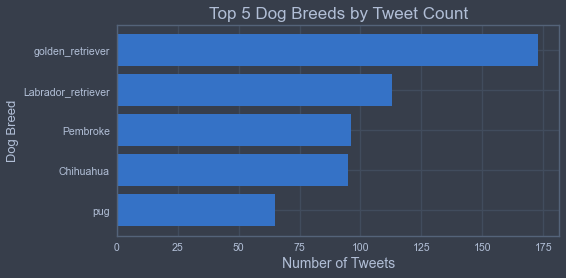

In [73]:
plt.barh(top5_breeds_count.index, top5_breeds_count)

plt.xlabel('Number of Tweets', fontsize = 14)
plt.ylabel('Dog Breed', fontsize = 13)
plt.title('Top 5 Dog Breeds by Tweet Count', fontsize = 17)
plt.gca().invert_yaxis()
plt.show();

The bar chart titled Top 5 Dog Breeds by Tweet Count shows that has the highest frequency in relation to number of tweets as being the Golden Retriever.The other breeds are also in the top 5 of being popular.

My concusion is that the dog Golden retriever is the most popular and liked in terms of number of tweet count and favourite count as analyzed earlier in our favourite count section as we analyzed and cleaned the data.